# Machine Learning Project: Key Detection
Authors: Zach Hayes, Matt Gaetano, Max Ivry

Course: CS3540


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

from keras.api.utils import to_categorical
from keras.api.models import Sequential
from keras.api.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D
from keras.api.regularizers import L2
from keras.api.callbacks import EarlyStopping
from keras.api import optimizers

### Gather Training and Testing Data
Data cleaning and feature extraction occured earlier in process. See clean.ipynb

In [2]:
def retrieve_data(square_data = False):
    train_df = pd.read_json("train.json", lines=True)

    def combine_equal(df):
        # Combine "tonally equivalent" classes by replacing some labels
        tonal_equ = {
                "A#": "Bb",
                "B#": "C",
                "C#": "Db",
                "D#": "Eb",
                "E#": "F",
                "F#": "Gb",
                "G#": "Ab"
            }
    
        df[['note', 'modality']] = pd.DataFrame(df.target.tolist(), index=df.index)
        df["note"] = df['note'].replace(tonal_equ)
        df["target"] = df[["note", "modality"]].astype(str).apply(' '.join, axis=1)
        df.drop(["note", "modality"], axis=1, inplace=True)

    combine_equal(train_df)

    def reduce_to_perfect_square(df):
        # function to randomly drop features to make data into perfect square for CNN input . . .
        num_features = df.shape[1]
        max_square = int(np.sqrt(num_features)) ** 2

        if max_square == num_features:
            return df
        else:
            features_to_drop = num_features - max_square-1
            target = df["target"]
            reduced_df = df.drop(columns=["target"])
            dropped_features = np.random.choice(reduced_df.columns, size=features_to_drop, replace=False)
            reduced_df = reduced_df.drop(columns=dropped_features)
            reduced_df["target"] = target
            return reduced_df

    if square_data:
        train_df = reduce_to_perfect_square(train_df)

    return train_test_split(train_df.drop(columns=['target']), train_df["target"], test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = retrieve_data()
all_keys = y_train.unique()

### Visualization: PCA

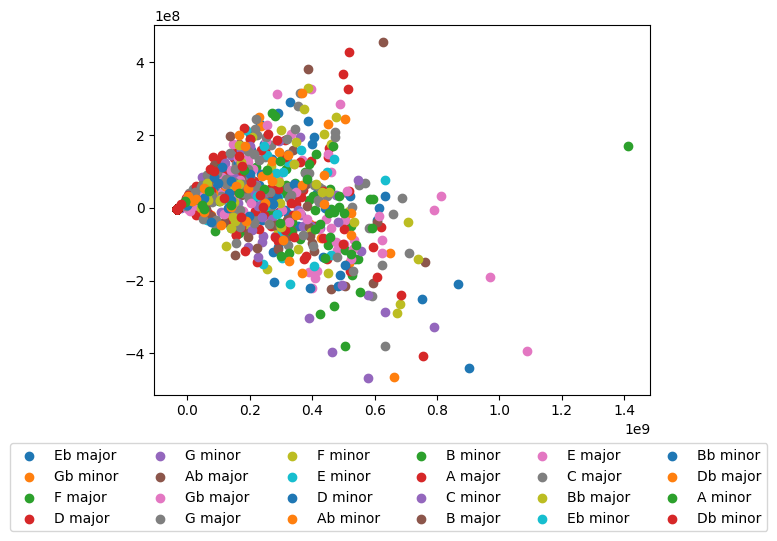

In [7]:
# PCA for initial visualization
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(X_train)

transformed_df = pd.DataFrame(transformed_data, columns=["x", "y"])
transformed_df = transformed_df.join(y_train)

fig = plt.figure()
ax = fig.add_subplot()
for key in all_keys:
  samples = transformed_df[transformed_df["target"] == key]
  ax.scatter(x=samples["x"], y=samples["y"], label=key)
plt.legend(loc='right', bbox_to_anchor=(1.25, -0.25), ncol=6)

### Machine Learning Approach 1:
### Logistic Regression Full Key Classification

In [5]:
# Running this should take about 10 Minutes

log_reg = LogisticRegression()

# Use grid search to find the best regularization for the data
param_grid = {
    'C': [1, 10, 1000, 10000]
}
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

log_reg = LogisticRegression(C=best_params["C"])

C:\Users\Zachary\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
log_reg.fit(X_train, y_train)
log_reg_results = log_reg.predict(X_test)

def conf_matrix_to_df(conf_matrix, target_names):
    return pd.DataFrame(conf_matrix, columns=target_names, index=target_names)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=log_reg_results)
conf_matrix_to_df(conf_matrix, all_keys)

C:\Users\Zachary\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Eb major,Gb minor,F major,D major,G minor,Ab major,Gb major,G major,F minor,E minor,...,C minor,B major,E major,C major,Bb major,Eb minor,Bb minor,Db major,A minor,Db minor
Eb major,94,5,0,0,0,0,0,0,0,0,...,4,3,0,0,0,0,0,0,0,3
Gb minor,2,79,0,3,0,0,0,0,5,0,...,1,3,0,0,0,0,3,1,0,0
F major,0,0,50,4,0,0,0,2,0,0,...,0,0,2,3,0,4,0,0,2,0
D major,0,0,1,43,3,0,0,0,0,0,...,0,1,0,1,0,0,0,0,2,0
G minor,0,0,0,0,76,3,0,0,0,0,...,6,0,0,0,0,0,0,0,4,1
Ab major,0,0,0,0,8,34,0,0,0,0,...,1,8,0,0,0,0,1,0,0,0
Gb major,0,0,0,0,1,0,88,0,0,2,...,0,0,6,0,9,0,0,7,0,0
G major,0,0,0,0,0,0,2,37,0,1,...,0,0,1,0,1,4,0,0,0,0
F minor,0,2,0,0,0,0,0,0,119,2,...,0,0,0,0,8,0,6,3,0,0
E minor,0,0,0,0,0,0,5,1,2,54,...,0,0,6,0,2,1,0,8,0,0


Text(0.5, 1.0, 'Logistic Regression Confusion Matrix Heat Map')

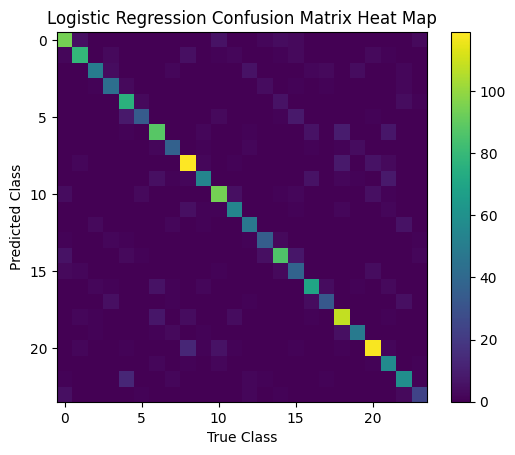

In [46]:
plt.imshow(conf_matrix)
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Logistic Regression Confusion Matrix Heat Map")

In [8]:
print(classification_report(y_true=y_test, y_pred=log_reg_results))

              precision    recall  f1-score   support

     A major       0.81      0.80      0.81       117
     A minor       0.86      0.79      0.82       100
    Ab major       0.86      0.68      0.76        73
    Ab minor       0.74      0.78      0.76        55
     B major       0.72      0.84      0.78        90
     B minor       0.81      0.62      0.70        55
    Bb major       0.79      0.77      0.78       114
    Bb minor       0.76      0.77      0.76        48
     C major       0.80      0.84      0.82       141
     C minor       0.83      0.68      0.75        79
     D major       0.82      0.82      0.82       115
     D minor       0.81      0.82      0.81        66
    Db major       0.76      0.80      0.78        59
    Db minor       0.74      0.80      0.77        44
     E major       0.81      0.78      0.80       110
     E minor       0.59      0.75      0.66        51
    Eb major       0.78      0.78      0.78        90
    Eb minor       0.79    

### Machine Learning Approach 2:
### Random Forest

In [3]:
# Running this should take about _ Minutes
"""
rf = RandomForestClassifier(random_state=42)

# Use grid search to find the best regularization for the data
param_grid = {
    'n_estimators': [1000, 2000],
    'criterion': ["gini", "entropy"],
    'max_depth': [None, 500, 1000],
    'min_samples_split': [2, 10]
}

n_models = 10
random_search = RandomizedSearchCV(estimator=rf,
                                   scoring="accuracy",
                                   param_distributions=param_grid,
                                   cv=None,
                                   n_iter=n_models,
                                   n_jobs=-1)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

"""

KeyboardInterrupt: 

In [96]:
#print(best_params)

{'min_samples_split': 2, 'max_depth': 200, 'criterion': 'entropy'}


              precision    recall  f1-score   support

     A major       0.58      0.81      0.68       117
     A minor       0.82      0.73      0.77       100
    Ab major       0.68      0.71      0.70        73
    Ab minor       0.85      0.31      0.45        55
     B major       0.57      0.73      0.64        90
     B minor       0.88      0.25      0.39        55
    Bb major       0.66      0.78      0.71       114
    Bb minor       0.69      0.19      0.30        48
     C major       0.74      0.89      0.81       141
     C minor       0.84      0.58      0.69        79
     D major       0.67      0.90      0.77       115
     D minor       0.90      0.53      0.67        66
    Db major       0.56      0.83      0.67        59
    Db minor       0.94      0.39      0.55        44
     E major       0.60      0.85      0.70       110
     E minor       1.00      0.49      0.66        51
    Eb major       0.68      0.84      0.75        90
    Eb minor       0.95    

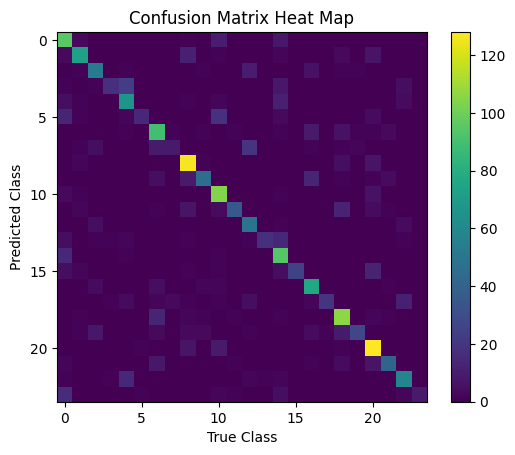

In [4]:
"""rf = RandomForestClassifier(n_estimators=best_params["n_estimators"],
                            criterion=best_params["criterion"],
                            max_depth=best_params["max_depth"],
                            min_samples_split=best_params["min_samples_split"],
                            n_jobs=-1)"""
xtrain = normalize(X_train)
xtest_rf = normalize(X_test)

rf = RandomForestClassifier(n_estimators=2000, criterion="entropy", max_depth=50, random_state=42, n_jobs=-1)
rf.fit(xtrain, y_train)
rf_results = rf.predict(xtest_rf)

def conf_matrix_to_df(conf_matrix, target_names):
    return pd.DataFrame(conf_matrix, columns=target_names, index=target_names)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=rf_results)
plt.imshow(conf_matrix)
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Confusion Matrix Heat Map")
print(classification_report(y_true=y_test, y_pred=rf_results))

### Machine Learning Approach 3:
### Shallow Fully Connected Neural Network

In [41]:
NUM_CLASSES = len(all_keys)
all_keys_int = [i for i, key in enumerate(all_keys)]
KEY_IDS = dict(zip(all_keys, all_keys_int))

# Split the training data into train and validation
xtrain, xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
xtrain = normalize(xtrain)
xval = normalize(xval)
xtest_nn = normalize(X_test)
ytest = y_test

# Use SMOTE to augment the training data
sm = SMOTE(random_state=42)
xtrain, ytrain = sm.fit_resample(X=xtrain, y=ytrain)

# Convert the labels to integers
ytrain = ytrain.replace(to_replace=KEY_IDS)
yval = yval.replace(to_replace=KEY_IDS)
ytest = ytest.replace(to_replace=KEY_IDS)
# Map the targets to 1-Hot encoding of all 24 classes
ytrain_1hot = to_categorical(ytrain, num_classes=NUM_CLASSES)
yval_1hot = to_categorical(yval, num_classes=NUM_CLASSES)
ytest_1hot = to_categorical(ytest, num_classes=NUM_CLASSES)

print(f'X Train Shape: {xtrain.shape}, Y Train Shape: {ytrain_1hot.shape}')
print(f'X Val Shape: {xval.shape}, Y Val Shape: {yval_1hot.shape}')
print(f'X Test Shape: {xtest_nn.shape}, Y Test Shape: {ytest_1hot.shape}')

X Train Shape: (11808, 5000), Y Train Shape: (11808, 24)
X Val Shape: (1576, 5000), Y Val Shape: (1576, 24)
X Test Shape: (1970, 5000), Y Test Shape: (1970, 24)


In [42]:
l2_reg = 0.0005
def neural_network_train():
    layers = [
        Flatten(),
        Dense(25,
              activation="relu",
              kernel_regularizer=L2(l2_reg)
        ),
        Dense(25,
              activation="relu",
              kernel_regularizer=L2(l2_reg)
        ),
        Dropout(0.1),
        Dense(NUM_CLASSES, activation="softmax")
    ]

    model = Sequential(layers)
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['acc'])

    return model

nn_model = neural_network_train()

In [27]:
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │       125,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           624 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,899 (1.45 MB)

 Trainable params: 126,299 (493.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 252,600 (986.72 KB)

Epoch 1/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.0603 - loss: 3.2061 - val_acc: 0.1187 - val_loss: 3.1761
Epoch 2/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.1141 - loss: 3.1587 - val_acc: 0.1542 - val_loss: 3.1270
Epoch 3/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.1392 - loss: 3.0966 - val_acc: 0.1707 - val_loss: 3.0676
Epoch 4/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.1704 - loss: 3.0266 - val_acc: 0.1986 - val_loss: 2.9933
Epoch 5/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.1864 - loss: 2.9493 - val_acc: 0.2151 - val_loss: 2.9102
Epoch 6/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.2000 - loss: 2.8558 - val_acc: 0.2297 - val_loss: 2.8200
Epoch 7/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.2137 - loss: 2.7698 - val_acc: 0.2500 - val_loss: 2.7266
Epoch 8/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.2427 - loss: 2.6731 - val_acc: 0.2646 - val_loss: 2.6321
Epoch 9/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.271

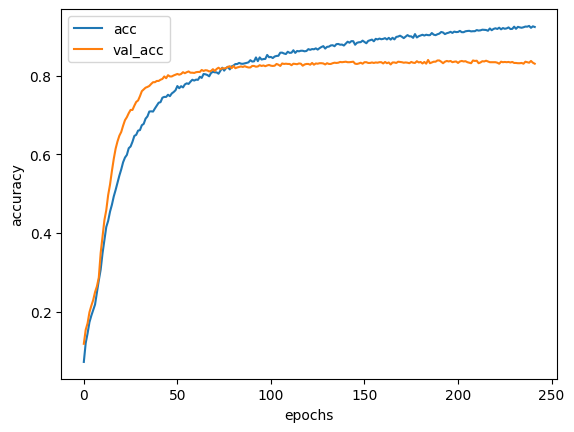

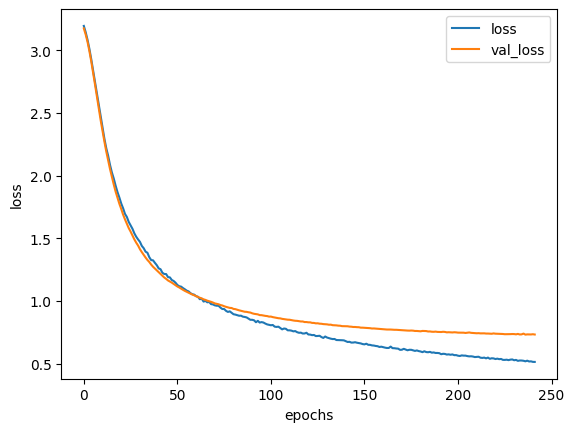

In [43]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
nn_history = nn_model.fit(xtrain,
                        ytrain_1hot,
                        batch_size=128,
                        epochs=500,
                        validation_data=(xval, yval_1hot),
                        callbacks=[early_stop])

plt.figure(0)
plt.plot(nn_history.history['acc'], label="acc")
plt.plot(nn_history.history['val_acc'], label="val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.figure(1)
plt.plot(nn_history.history['loss'], label="loss")
plt.plot(nn_history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8136 - loss: 0.8046
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.78      0.80      0.79        90
           1       0.75      0.75      0.75        36
           2       0.88      0.78      0.83       128
           3       0.81      0.83      0.82       115
           4       0.84      0.92      0.88        64
           5       0.88      0.73      0.80        73
           6       0.79      0.74      0.76        80
           7       0.89      0.79      0.84       146
           8       0.78      0.88      0.83        60
           9       0.72      0.80      0.76        51
          10       0.78      0.80      0.79        66
          11       0.81      0.87      0.84        55
          12       0.79      0.80      0.79        55
          13       0.87      0.87      0.87       117
          14       0.76      0.72      0.74        79
          15       0.80     

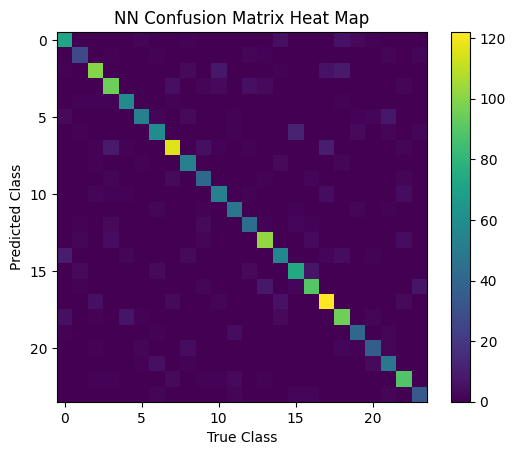

In [44]:
nn_model.evaluate(xtest_nn, ytest_1hot)

ypredict = nn_model.predict(xtest_nn)
yclasses = ypredict.argmax(axis=-1)
conf_matrix = confusion_matrix(y_true=ytest, y_pred=yclasses)

plt.figure(2)
plt.imshow(conf_matrix, cmap="viridis")
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("NN Confusion Matrix Heat Map")

print(classification_report(y_true=ytest, y_pred=yclasses))

### Machine Learning Approach 4:
### Convolutional Neural Network

In [38]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = retrieve_data(square_data=True)

NUM_CLASSES = len(all_keys)
all_keys_int = [i for i, key in enumerate(all_keys)]
KEY_IDS = dict(zip(all_keys, all_keys_int))

# Split the training data into train and validation
xtrain, xval, ytrain, yval = train_test_split(X_train_cnn, y_train_cnn, test_size=0.2, random_state=42)
xtrain = normalize(xtrain)
xval = normalize(xval)
xtest_cnn = normalize(X_test_cnn)
ytest = y_test_cnn

# Use SMOTE to augment the training data
sm = SMOTE(random_state=42)
xtrain, ytrain = sm.fit_resample(X=xtrain, y=ytrain)

# Convert the labels to integers
ytrain = ytrain.replace(to_replace=KEY_IDS)
yval = yval.replace(to_replace=KEY_IDS)
ytest = ytest.replace(to_replace=KEY_IDS)
# Map the targets to 1-Hot encoding of all 24 classes
ytrain_1hot = to_categorical(ytrain, num_classes=NUM_CLASSES)
yval_1hot = to_categorical(yval, num_classes=NUM_CLASSES)
ytest_1hot = to_categorical(ytest, num_classes=NUM_CLASSES)

# Reshape all x sets
xtrain = xtrain.reshape(-1, 70, 70, 1)
xval = xval.reshape(-1, 70, 70, 1)
xtest_cnn = xtest_cnn.reshape(-1, 70, 70, 1)

print(f'X Train Shape: {xtrain.shape}, Y Train Shape: {ytrain_1hot.shape}')
print(f'X Val Shape: {xval.shape}, Y Val Shape: {yval_1hot.shape}')
print(f'X Test Shape: {xtest_cnn.shape}, Y Test Shape: {ytest_1hot.shape}')

X Train Shape: (11808, 70, 70, 1), Y Train Shape: (11808, 24)
X Val Shape: (1576, 70, 70, 1), Y Val Shape: (1576, 24)
X Test Shape: (1970, 70, 70, 1), Y Test Shape: (1970, 24)


In [39]:
# Defining the CNN architecture . . .
cnn_model = Sequential([
    Input(shape=(70, 70, 1)),
    Conv2D(32, kernel_size=(12, 12), strides=(2, 2), activation='relu'),
    Conv2D(64, kernel_size=(5, 5), strides=(1, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1024, activation='relu', kernel_regularizer=L2(0.05)),
    Dropout(0.25),
    Dense(NUM_CLASSES, activation='softmax')
])

lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=2000,
    decay_rate=0.95,
    staircase=True)

optimizer = optimizers.Adam(learning_rate=lr_schedule)
cnn_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 13, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4992)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     5,112,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 24)             │        24,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,193,336 (19.81 MB)

 Trainable params: 5,193,336 (19.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - acc: 0.1395 - loss: 27.2889 - val_acc: 0.6155 - val_loss: 1.8275
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - acc: 0.6893 - loss: 1.5820 - val_acc: 0.6935 - val_loss: 1.4933
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - acc: 0.7636 - loss: 1.3086 - val_acc: 0.7348 - val_loss: 1.2899
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - acc: 0.7836 - loss: 1.1680 - val_acc: 0.7443 - val_loss: 1.1997
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - acc: 0.7939 - loss: 1.0953 - val_acc: 0.7481 - val_loss: 1.1856
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - acc: 0.8052 - loss: 1.0232 - val_acc: 0.7373 - val_loss: 1.2028
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - acc: 0.8229 - loss: 0.9562 - val_acc: 0.7824 - val_loss: 1.0494
Epoch 8/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - acc: 0.8229 - loss: 0.9446 - val_acc: 0.7684 - val_loss: 1.1154
Epoch 9/50
185/185 ━━━━━━━━━━━━━━━━━━

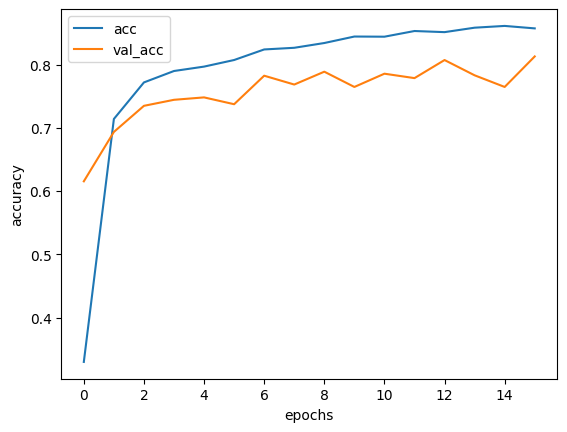

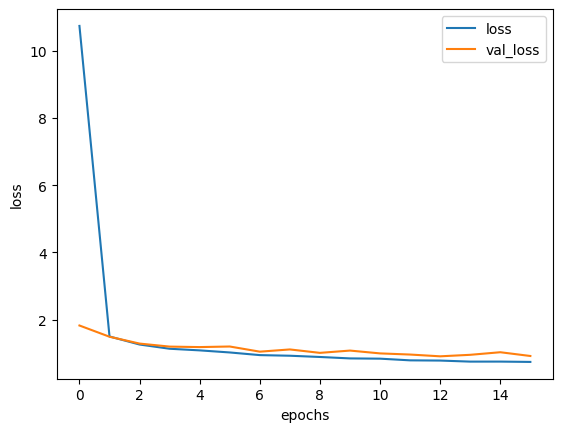

In [40]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = cnn_model.fit(xtrain,
                    ytrain_1hot,
                    validation_data=(xval, yval_1hot),
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stop]
)

plt.figure(0)
plt.plot(history.history['acc'], label="acc")
plt.plot(history.history['val_acc'], label="val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.8096 - loss: 0.8190
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

           0       0.80      0.81      0.81        90
           1       0.73      0.75      0.74        36
           2       0.88      0.77      0.82       128
           3       0.87      0.72      0.79       115
           4       0.71      0.94      0.81        64
           5       0.76      0.74      0.75        73
           6       0.73      0.86      0.79        80
           7       0.80      0.90      0.85       146
           8       0.94      0.80      0.86        60
           9       0.81      0.75      0.78        51
          10       0.70      0.94      0.81        66
          11       0.71      0.95      0.81        55
          12       0.84      0.76      0.80        55
          13       0.81      0.95      0.87       117
          14       0.84      0.77      0.80        79
          15       0.83   

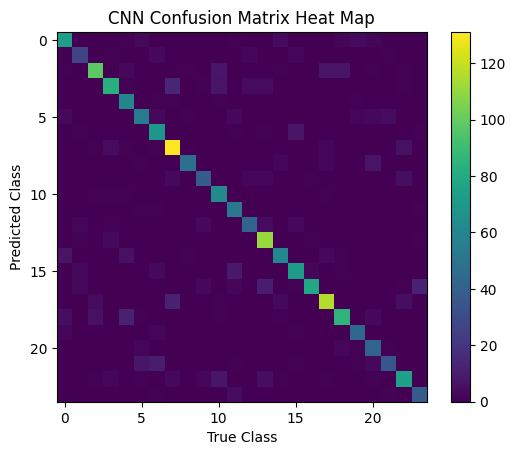

In [37]:
cnn_model.evaluate(xtest_cnn, ytest_1hot)

ypredict = cnn_model.predict(xtest_cnn)
yclasses = ypredict.argmax(axis=-1)
conf_matrix = confusion_matrix(y_true=ytest, y_pred=yclasses)

plt.figure(2)
plt.imshow(conf_matrix, cmap="viridis")
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("CNN Confusion Matrix Heat Map")

print(classification_report(y_true=ytest, y_pred=yclasses))

### Ensemble Approach

In [17]:
# Build a custom voting classifier for the pretrained models and their particular inputs
class KeyVotingClassifier:
    def __init__(self, models: dict):
        self.models = models

    def __predict(self, inputs):
        """
        Gives probabilistic predictions for each classifier
        using the given test inputs. Compiles into one array
        """
        # Order log reg and rf keys
        self.models["log_reg"].classes_ = np.array(list(KEY_IDS.keys()))
        if "rf" in self.models:
            self.models["rf"].classes_ = np.array(list(KEY_IDS.keys()))

        # Get the probabilities for each model
        pred_log_reg = self.models["log_reg"].predict_proba(inputs["log_reg"])
        pred_nn = self.models["nn"].predict(inputs["nn"])
        pred_cnn = self.models["cnn"].predict(inputs["cnn"])
        pred_rf = None
        if "rf" in self.models:
            pred_rf = self.models["rf"].predict_proba(inputs["rf"])

        if "rf" in self.models:
            return np.array([pred_log_reg, pred_nn, pred_cnn, pred_rf])
        return np.array([pred_log_reg, pred_nn, pred_cnn])

    def soft_vote(self, inputs: dict):
        """
        Predicts the output classes of test data using soft voting
        with the estimator models given.
        """
        pred_avg = np.mean(self.__predict(inputs), axis=0)
        pred = np.apply_along_axis(lambda x: np.argmax(x), axis=1, arr=pred_avg)
        return pred

    def hard_vote(self, inputs: dict):
        """
        Predicts the output class of the test data using hard voting
        with the estimator models given.
        """
        pred_votes = np.apply_along_axis(lambda x: np.argmax(x), axis=2, arr=self.__predict(inputs))
        pred = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=pred_votes)
        return pred


In [31]:
classifiers = {"log_reg": log_reg, "nn": nn_model, "cnn": cnn_model, "rf": rf}
ensemble = KeyVotingClassifier(classifiers)
test_inputs = {"log_reg": X_test, "nn": xtest_nn, "cnn": xtest_cnn, "rf": xtest_rf}

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

           0       0.34      0.82      0.48        90
           1       0.23      0.72      0.35        36
           2       0.57      0.71      0.63       128
           3       0.71      0.69      0.70       115
           4       0.34      0.89      0.49        64
           5       0.43      0.22      0.29        73
           6       0.34      0.72      0.46        80
           7       0.77      0.77      0.77       146
           8       0.26      0.80      0.39        60
           9       0.47      0.75      0.58        51
          10       0.58      0.80      0.67        66
          11       0.88      0.55      0.67        55
          12       0.34      0.47      0.40        55
          13       0.39      0.12      0.18       117
          14       0.19      0.28      0.23        79
          15       0.69      0.10      0.17        90
  

Text(0.5, 1.0, 'Hard Voting Confusion Matrix Heat Map')

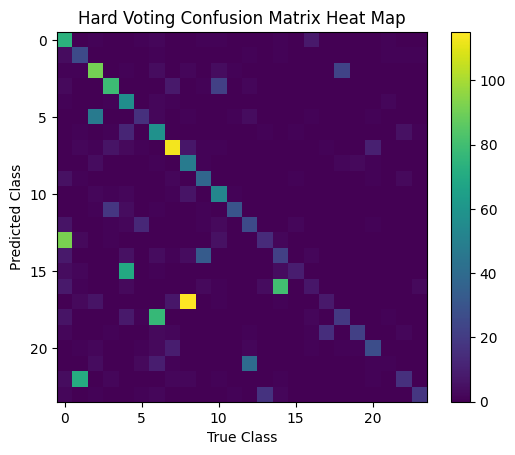

In [32]:
pred_hard = ensemble.hard_vote(test_inputs)
print(classification_report(y_true=ytest, y_pred=pred_hard))
conf_matrix = confusion_matrix(y_true=ytest, y_pred=pred_hard)
plt.figure(0)
plt.imshow(conf_matrix, cmap="viridis")
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Hard Voting Confusion Matrix Heat Map")

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

           0       0.71      0.78      0.74        90
           1       0.66      0.81      0.72        36
           2       0.86      0.70      0.77       128
           3       0.84      0.66      0.74       115
           4       0.67      0.89      0.77        64
           5       0.78      0.73      0.75        73
           6       0.78      0.84      0.81        80
           7       0.84      0.83      0.83       146
           8       0.73      0.85      0.78        60
           9       0.75      0.75      0.75        51
          10       0.59      0.86      0.70        66
          11       0.86      0.93      0.89        55
          12       0.75      0.78      0.77        55
          13       0.86      0.91      0.88       117
          14       0.73      0.76      0.75        79
          15       0.81      0.81      0.81        90
  

Text(0.5, 1.0, 'Soft Voting Confusion Matrix Heat Map')

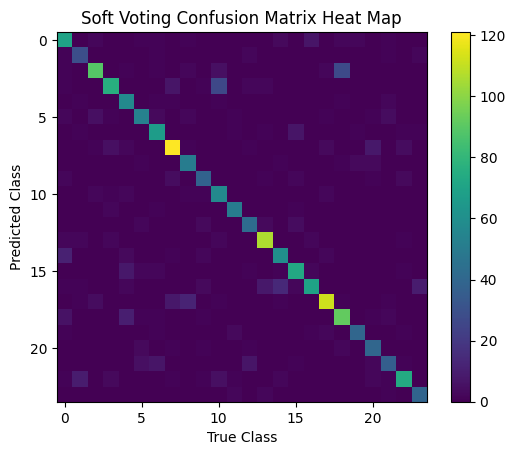

In [33]:
pred_soft = ensemble.soft_vote(test_inputs)
print(classification_report(y_true=ytest, y_pred=pred_soft))
conf_matrix = confusion_matrix(y_true=ytest, y_pred=pred_soft)
plt.figure(1)
plt.imshow(conf_matrix, cmap="viridis")
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Soft Voting Confusion Matrix Heat Map")

In [34]:
classifiers = {"log_reg": log_reg, "nn": nn_model, "cnn": cnn_model}
ensemble = KeyVotingClassifier(classifiers)
test_inputs = {"log_reg": X_test, "nn": xtest_nn, "cnn": xtest_cnn}

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

           0       0.64      0.91      0.75        90
           1       0.41      0.86      0.55        36
           2       0.82      0.88      0.85       128
           3       0.76      0.82      0.79       115
           4       0.53      0.94      0.67        64
           5       0.73      0.71      0.72        73
           6       0.67      0.79      0.72        80
           7       0.76      0.84      0.80       146
           8       0.71      0.93      0.81        60
           9       0.71      0.76      0.74        51
          10       0.81      0.82      0.81        66
          11       0.80      0.87      0.83        55
          12       0.85      0.71      0.77        55
          13       0.81      0.81      0.81       117
          14       0.76      0.66      0.71        79
          15       0.91      0.70      0.79        90
  

Text(0.5, 1.0, 'Hard Voting Confusion Matrix Heat Map - No RF')

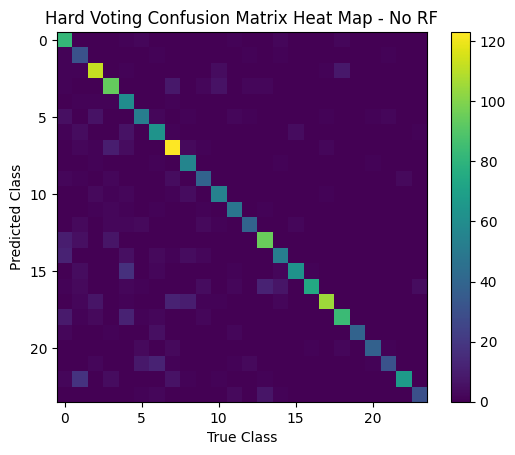

In [35]:
pred_hard = ensemble.hard_vote(test_inputs)
print(classification_report(y_true=ytest, y_pred=pred_hard))
conf_matrix = confusion_matrix(y_true=ytest, y_pred=pred_hard)
plt.figure(0)
plt.imshow(conf_matrix, cmap="viridis")
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Hard Voting Confusion Matrix Heat Map - No RF")

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

           0       0.74      0.81      0.77        90
           1       0.81      0.83      0.82        36
           2       0.91      0.78      0.84       128
           3       0.83      0.74      0.78       115
           4       0.71      0.92      0.80        64
           5       0.76      0.79      0.78        73
           6       0.77      0.85      0.81        80
           7       0.84      0.88      0.86       146
           8       0.90      0.87      0.88        60
           9       0.73      0.75      0.74        51
          10       0.70      0.86      0.78        66
          11       0.88      0.95      0.91        55
          12       0.81      0.80      0.81        55
          13       0.86      0.92      0.89       117
          14       0.85      0.76      0.80        79
          15       0.82      0.84      0.83        90
  

Text(0.5, 1.0, 'Soft Voting Confusion Matrix Heat Map - No RF')

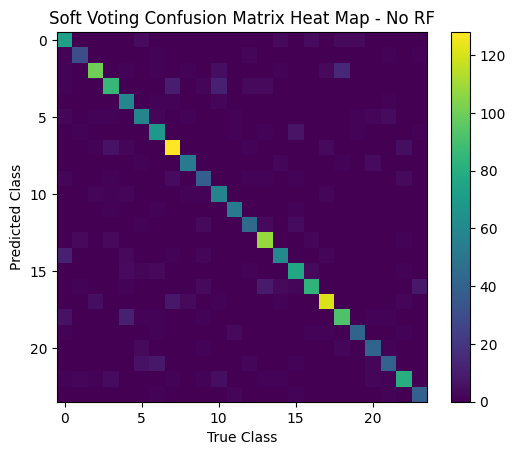

In [36]:
pred_soft = ensemble.soft_vote(test_inputs)
print(classification_report(y_true=ytest, y_pred=pred_soft))
conf_matrix = confusion_matrix(y_true=ytest, y_pred=pred_soft)
plt.figure(1)
plt.imshow(conf_matrix, cmap="viridis")
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Soft Voting Confusion Matrix Heat Map - No RF")